#Задача: сентимент-анализ предложений из текста "Мастер и Маргарита"

Построим [KNN-классификатор](https://ru.wikipedia.org/wiki/Метод_k-ближайших_соседей) на ручной разметке (~400 примеров). Чтобы его построить нам нужно извлечь признаки из разметки, поэтому построим модель векторного пространства (попробуем [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) и [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF))


## №1. Подготовка окружения

### 1.1 Устанавливаем необходимые библиотеки

In [66]:
# workaround for pymystem3

!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2020-04-25 01:49:22--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.245, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskstoredata03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-04-25 01:49:22--  http://cache-mskstoredata03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskstoredata03.cdn.yandex.net (cache-mskstoredata03.cdn.yandex.net)... 37.9.96.14, 2a02:6b8:0:3706::12
Connecting to cache-mskstoredata03.cdn.yandex.net (cache-mskstoredata03.cdn.yandex.net)|37.9.96.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-

In [67]:
# libraries for calculating Levenshtein distance between words

!pip install fuzzywuzzy
!pip install python-Levenshtein

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import re

/home/andrey/PycharmProjects/sentences_analysis/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [69]:
# library for interacting with Google Drive

!pip install -U -q PyDrive

### 1.2 Загружаем файл разметки

#### для Google Colab

In [1]:
# data links to files in GDrive:
dataset_sheetname = 'ПРЕДЛОЖЕНИЯ'
link_to_dataset = 'https://docs.google.com/spreadsheets/d/1fyqJ3oIc-UAKpqHzgzS7PKaij9Nhg-1KtqEMLo4uHu0/edit#gid=0'
_, book_id = link_to_dataset.split('=')

In [71]:
# Code to read csv file into Colaboratory:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# 
# import gspread
# 
# # Authenticate and create the PyDrive client.
# gauth = GoogleAuth()
# auth.authenticate_user()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# gc = gspread.authorize(gauth.credentials)
# 
# # open excel-file
# wb = gc.open_by_url(link_to_dataset)
# sheet = wb.worksheet(dataset_sheetname)
# all_data = sheet.get_all_values()

#### локально

In [1]:
data = pd.read_excel('data/KNN (1-3,5).xlsx')  

NameError: name 'pd' is not defined

## №2. Подготовка данных

In [4]:
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
mystem = Mystem()
# data = pd.DataFrame(data[1:], columns=data[0])

[nltk_data] Downloading package stopwords to /home/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция для предобработки предложений. Что она делает:
+ Лемматизация слов
+ Отбрасывание стоп-слов (частицы, союзы, местоимения)
+ Удаление знаков пунктуации


In [5]:
def preprocess_sentence(sentence):
    tokens = mystem.lemmatize(sentence.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    tokenized_sentence = " ".join(tokens)
    return tokenized_sentence   

Функция для предобротки меток (эмоций) из разметки:

+ Разбиение на отдельные классы
+ Нормализация классов (сведение более мягких эмоций к более сильным)
+ Проверка, что указана корректная эмоция (одна из эмоций по теории Келлермана-Плутчика)

In [2]:
emotions_table = {
    'восторг': 'восторг',
		'радость': 'восторг',
		'безмятежность': 'восторг',
    'восхищение': 'восхищение',
		'доверие': 'восхищение',
		'принятие': 'восхищение',
    'ужас': 'ужас',
		'страх': 'ужас',
		'тревога': 'ужас',
    'изумление': 'изумление',
		'удивление': 'изумление',
		'возбуждение': 'изумление',
    'горе': 'горе',
		'грусть': 'горе',
		'печаль': 'горе',
    'отвращение': 'отвращение',
		'неудовольствие': 'отвращение',
		'скука': 'отвращение',
    'гнев': 'гнев',
		'злость': 'гнев',
		'досада': 'гнев',
    'настороженность': 'настороженность',
		'ожидание': 'настороженность',
		'интерес': 'настороженность',
}

def normalize_emotion(emotion):
    emotion = emotion.lower()
    result = emotions_table.get(emotion)
    assert result is not None, f"Emotion '{emotion}' is not correct one."
    return result

Непосредственно предобработка данных из файла с разметкой:

In [8]:
processed_sentences = list(map(preprocess_sentence, data['Предложение']))
temp = pd.DataFrame(columns=['Предложение', 'Эмоция'])

for i, (emotion, sentence) in enumerate(zip(data['Эмоция'], processed_sentences)):
    if any(delim in emotion for delim in (' ', ',', '.', '\n')):
        emotions = [normalize_emotion(e) for e in re.split('[ ,.\n]', emotion.strip()) if e != '']
        # for e in emotions:
        #     temp = temp.append({'Предложение': sentence, 'Эмоция': e}, ignore_index=True)
        temp = temp.append({'Предложение': sentence, 'Эмоция': emotions[0]}, ignore_index=True)
    else:
        temp = temp.append({'Предложение': sentence, 'Эмоция': normalize_emotion(emotion)}, ignore_index=True)

processed_data = temp
print(processed_data)

## №3. Моделирование



### 3.1 Bag-of-Words
Строим модель текста по разметке используя модель называемую "Мешок Слов"

In [11]:
vectorizer_count = CountVectorizer()
vectorizer_count.fit(processed_data['Предложение'])

# encode document
count_vec_matrix = vectorizer_count.transform(processed_data['Предложение'])

NameError: name 'processed_data' is not defined

### 3.2 TF-IDF

In [78]:
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(processed_data['Предложение'])

# encode document
tfidf_vec_matrix = vectorizer_tfidf.transform(processed_data['Предложение'])

## №4. Классификация

In [10]:
from typing import List, Iterable, Dict, Tuple

import collections
import functools
import itertools
import multiprocessing
import scipy
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()

### 4.1 Обучение классификатора 
Строим модели с разнами разбиениями датасета и разными k для KNN.

In [5]:
DEFAULT_COLORS = ['red', 'green', 'orange', 'purple', 'blue', 'gray', 'pink']
DEFAULT_SPLITS = [0.20, 0.30, 0.40, 0.50]

def get_colors(n):
  colors = DEFAULT_COLORS[:n]
  if n > len(DEFAULT_COLORS):
    import matplotlib, random
    all_colours = matplotlib.colors.get_named_colors_mapping()
    colors.extend(random.choices(all_colours, k=n-len(DEFAULT_COLORS)))
  return colors

def _knn_analysis(X, y, splits, k_interval) -> Tuple[List[List[float]], List[List[float]], Dict[str, int]]:
  error_over_splits_train = []
  error_over_splits_test = []
  best_result = {'split': 0, 'k': 0, 'error': 1}
  for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    #---------------------
    # here could be scaler
    #---------------------
    # Comparing Error Rate with the K Value
    # (calculating error for K values in k_range)
    error_for_one_split = []
    
    err_one_split_test = []
    err_one_split_train = []
    
    for i in k_interval:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        
        err_train_tmp = np.mean(y_train != y_train_predict)
        err_test_tmp = np.mean(y_test != y_test_predict)
        
        err_one_split_test.append(err_test_tmp)
        err_one_split_train.append(err_train_tmp)
        
        # check the best result
        if err_test_tmp < best_result['error']:
            best_result['split'] = split
            best_result['k'] = i
            best_result['error'] = err_test_tmp
    error_over_splits_train.append(err_one_split_train)
    error_over_splits_test.append(err_one_split_test)
  return error_over_splits_train, error_over_splits_test, best_result

NameError: name 'Tuple' is not defined

### 4.2 Визуализация результатов

In [12]:
def visualize_knn_analysis(X, y, splits=None, min_k=1, max_k=40):
  if not splits:
    splits = DEFAULT_SPLITS
  k_range = range(min_k, max_k+1)
  
  # Training and Predictions
  errors_over_splits_train, errors_over_splits_test, best_res = _knn_analysis(X, y, splits, k_range)
          
  # Plot results
  plt.figure(num=1, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_train, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)

  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Train Error')
  plt.legend(loc='best')
  
  plt.figure(num=2, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_test, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)
  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Test Error')
  plt.legend(loc='best')
  
  print("Best set:")
  print("Split: " + str(int((1 - best_res['split']) * 100)) + '%/' + str(int(best_res['split'] * 100)) + '%')
  print("K: " + str(best_res['k']))
  print("Error value: " + str(best_res['error']))

### 4.3 Оптимизация пространства признаков

In [6]:
def feature_optimize(X:scipy.sparse.csr_matrix, vectorizer, comparator, *, stemming=False, debug=False, **kwargs) -> scipy.sparse.csr_matrix:
  df = pd.DataFrame(X.toarray(), columns=vectorizer.vocabulary_)
  if debug:
    print(f'Columns before: {len(df.columns)}')

  # getting similar columns
  start = time.time()
  similar_col_groups = collections.defaultdict(set)
  if stemming:
    words_and_stems = {w: stemmer.stem(w) for w in df.columns}
    df = df.groupby(level=0, axis=1).sum()
  words = list(df.columns)
  for i, (w1, w2) in enumerate(filter(lambda word_pair: comparator(*word_pair, **kwargs), 
                                      itertools.combinations(words, 2)), 1):
    similar_col_groups[w1].add(w2)
    similar_col_groups[w2].add(w1)
    if debug:
      if i % 1000 == 0:
        print(f"{i} entries are matched by comparator")
  if debug:
    print('PROCESSING TIME:', time.time() - start)
    print(f'Got similar_col_groups (len: {len(similar_col_groups)})')
  
  _merge_intersecting_groups(similar_col_groups)
  if debug:
    print('Groups after merging:', len(similar_col_groups))

  df = join_columns(similar_col_groups.items(), df, debug)
  if debug:
    print(f'Columns after: {len(df.columns)}')
  return scipy.sparse.csr_matrix(df.values)

def _merge_intersecting_groups(similar_col_groups):
  def merge_subkeys_into_group(main_key, group, subkeys=None):
    if subkeys is None:
      subkeys = set(group)
    else:
      group.update(subkeys)
    for key in subkeys:
      if key in similar_col_groups:
        new_keys = similar_col_groups[key] - group - {key, main_key}
        if len(new_keys) > 0:
          merge_subkeys_into_group(main_key, group, new_keys)
        del similar_col_groups[key]
  for key in tuple(similar_col_groups.keys()):
    if key in similar_col_groups:
      group = similar_col_groups[key]
      merge_subkeys_into_group(key, group)
      
def join_columns(column_groups: Iterable[Tuple[str, Iterable[str]]], df: pd.DataFrame, debug) -> pd.DataFrame:
  if debug:
    print('DF in "join_columns":\n', df)
  for key, group in column_groups:
    for subkey in group:
      if subkey in df.columns:
        try:
          df[key] += df[subkey]
        except Exception as e:
          rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
          rendered_group = ", ".join(f"'{k}'" for k in group)
          print(f"key: '{key}'; subkey '{subkey}' [cols: {rendered_cols}] [group: {rendered_group}]")
          print(f"df[key]: {df[key]}; df[subkey]: {df[subkey]}")
          exit('ERROR')
        del df[subkey]
      elif debug:
        rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
        rendered_group = ", ".join(f"'{k}'" for k in group)
        print(f"key: '{key}'; subkey '{subkey}' do not exist in DF [cols: {rendered_cols}] [group: {rendered_group}]")
  return df

NameError: name 'scipy' is not defined

## №5. Анализ

### **5.1 Bag-of-Words + KNN**

#### **Baseline**

In [7]:
X = count_vec_matrix
y = processed_data['Эмоция'].to_numpy()

visualize_knn_analysis(X, y)

NameError: name 'count_vec_matrix' is not defined

По графику ошибки на обучающей выборке видно, что модель плохо обучается. На следующем этапе пробуем сократить число признаков(слов), объединив близкие по какому-либо критерию слова.

#### **Оптимизация с Левенштейном**
Пытаемся объединить близкие по расстоянию левенштейна слова.

##### **Без стемминга**

Best set:
Split: 80%/20%
K: 39
Error value: 0.5833333333333334


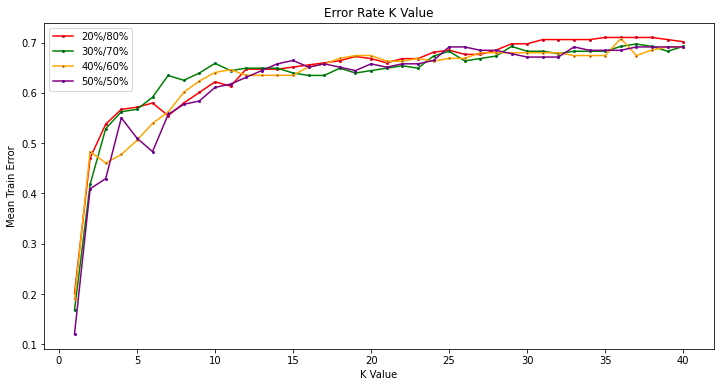

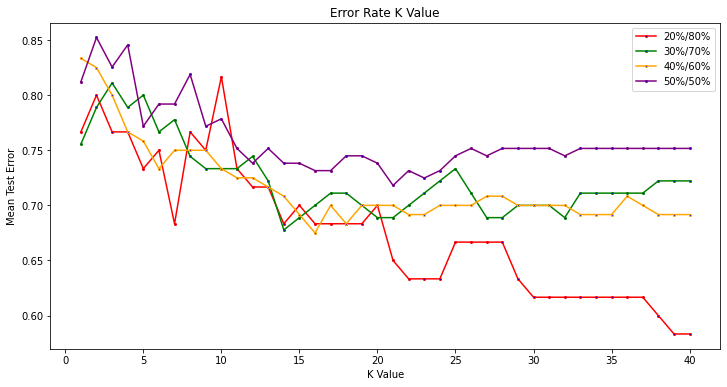

In [84]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

DEFAULT_THRESHOLD = 80

def levenshtein_similarity(word1, word2, threshold=DEFAULT_THRESHOLD) -> bool:
  return fuzz.WRatio(word1, word2) >= threshold

X_lev = feature_optimize(X, vectorizer_count, levenshtein_similarity, stemming=False, threshold=70)
visualize_knn_analysis(X_lev, y)

##### **Со стеммингом**

In [85]:
X_lev_stem = feature_optimize(X, vectorizer_count, levenshtein_similarity, stemming=True)
visualize_knn_analysis(X_lev_stem, y)

KeyboardInterrupt: 

#### **Оптимизация с n-grams**
Попробуем сравнивать слова по наличию между общих n-gramm (используя только одно n)

##### **Без стемминга**

In [ ]:
from nltk import ngrams

DEFAULT_NGRAM_SIZE = 3

def ngrams_eq_single_n(word1, word2, n=DEFAULT_NGRAM_SIZE):
  ng1, ng2 = list(ngrams(word1, n)), list(ngrams(word2, n))
  ngs_count = len(ng1) + len(ng2)
  diff = len(set(ng1).symmetric_difference(set(ng2)))
  if ngs_count == 0:
    return 0
  return 1 - diff/ngs_count


X_ng_single = feature_optimize(X, vectorizer_count, ngrams_eq_single_n)
visualize_knn_analysis(X_ng_single, y)


##### **Со стеммингом**

In [ ]:
X_ng_single_stem = feature_optimize(X, vectorizer_count, ngrams_eq_single_n, stemming=True)
visualize_knn_analysis(X_ng_single_stem, y)

#### **Оптимизация с n-grams (усреднённая)**
В качестве эксперимента попрбуем смотреть на усреднённую схожесть слов, возвращаемую через анализ определённых n-gramm.

##### **Без стемминга**

In [ ]:
import statistics

DEFAULT_BASE_NGRAM_SIZE = 3

def ngrams_eq_multi(w1, w2, n=DEFAULT_BASE_NGRAM_SIZE):
  return statistics.mean(ngrams_eq_single_n(w1, w2, i) for i in range(1, n+1))


X_ng_several_mean = feature_optimize(X, vectorizer_count, ngrams_eq_multi)
visualize_knn_analysis(X_ng_several_mean, y)

##### **Со стеммингом**

In [ ]:
X_ng_several_mean_stem = feature_optimize(X, vectorizer_count, ngrams_eq_multi, stemming=True)
visualize_knn_analysis(X_ng_several_mean_stem, y)

#### **Оптимизация с n-grams (взвешенная)**

Понятно, что схожесть по буквам имеет мало ценности, поэтому попробуем уменьшать вес схожести по малым n-grams

##### **Без стемминга**

In [ ]:
DEFAULT_MAX_NGRAM_SIZE = 3

def ngram_eq_multi_weighted(w1, w2, n=DEFAULT_MAX_NGRAM_SIZE):
  def inner(w1, w2, ni):
    ng1, ng2 = list(ngrams(w1, ni)), list(ngrams(w2, ni))
    ngs_count = len(ng1) + len(ng2)
    diff = len(set(ng1).symmetric_difference(set(ng2)))
    return diff, ngs_count
  res = [inner(w1, w2, i) for i in range(1, n+1)]
  # return 1 - sum(dif_i for dif_i, all_i in res) / sum(all_i for dif_i, all_i in res)
  return sum((1 - dif_i/all_i)*(0.1**(n-i)) if all_i > 0 else 0 for i, (dif_i, all_i) in enumerate(res, 1))


X_ng_multi = feature_optimize(X, vectorizer_count, ngram_eq_multi_weighted)
visualize_knn_analysis(X_ng_multi, y)

##### **Со стеммингом**

In [ ]:
X_ng_multi_n4 = feature_optimize(X, vectorizer_count, ngram_eq_multi_weighted, n=4)
visualize_knn_analysis(X_ng_multi_n4, y)

### **5.2 TF-IDF + KNN**

#### **Baseline**

In [ ]:
Xt = tfidf_vec_matrix
yt = processed_data['Эмоция'].to_numpy()

visualize_knn_analysis(Xt, yt)

#### **Оптимизация с Левенштейном**
Пытаемся объединить близкие по расстоянию левенштейна слова.

##### **Без стемминга**

In [ ]:
Xt_lev = feature_optimize(Xt, vectorizer_tfidf, levenshtein_similarity, stemming=False, threshold=70)
visualize_knn_analysis(Xt_lev, yt)

##### **Со стеммингом**

In [ ]:
Xt_lev_stem = feature_optimize(Xt, vectorizer_tfidf, levenshtein_similarity, stemming=True, threshold=70)
visualize_knn_analysis(Xt_lev_stem, yt)

#### **Оптимизация с n-grams**
Попробуем сравнивать слова по наличию между общих n-gramm (используя только одно n)

##### **Без стемминга**

In [ ]:
Xt_ng_single = feature_optimize(Xt, vectorizer_tfidf, ngrams_eq_single_n)
visualize_knn_analysis(Xt_ng_single, yt)

##### **Со стеммингом**

In [ ]:
Xt_ng_single_stem = feature_optimize(Xt, vectorizer_tfidf, ngrams_eq_single_n)
visualize_knn_analysis(Xt_ng_single_stem, yt)

#### **Оптимизация с n-grams (усреднённая)**
В качестве эксперимента попрбуем смотреть на усреднённую схожесть слов, возвращаемую через анализ определённых n-gramm.

##### **Без стемминга**

In [ ]:
Xt_ng_several_mean = feature_optimize(Xt, vectorizer_tfidf, ngrams_eq_multi)
visualize_knn_analysis(Xt_ng_several_mean, yt)

##### **Со стеммингом**

In [ ]:
Xt_ng_several_mean_stem = feature_optimize(Xt, vectorizer_tfidf, ngrams_eq_multi, stemming=True)
visualize_knn_analysis(X_ng_several_mean_stem, yt)

#### **Оптимизация с n-grams (взвешенная)**

Понятно, что схожесть по буквам имеет мало ценности, поэтому попробуем уменьшать вес схожести по малым n-grams

##### **Без стемминга**

In [ ]:
n = 4

Xt_ng_multi = feature_optimize(Xt, vectorizer_tfidf, ngram_eq_multi_weighted, n=n)
visualize_knn_analysis(X_ng_multi, yt)

##### **Со стеммингом**

In [ ]:
Xt_ng_multi_stem = feature_optimize(Xt, vectorizer_tfidf, ngram_eq_multi_weighted, n=n, stemming=True)
visualize_knn_analysis(Xt_ng_multi_stem, yt)

#### **Оптимизация с WordToVec**
Пытаемся объединить близкие по смыслу слова.
Используем корпус *tayga_none_fasttextcbow_300_10_2019*

In [15]:
import gensim
from gensim.models import Word2Vec

model = gensim.models.KeyedVectors.load('data/corpus/model.model')

def are_words_close(word1, word2, threshold=0.5):
    return True if model.wv.similarity(word1, word2) > threshold else False

In [16]:
from typing import List, Iterable, Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score

DEFAULT_COLORS = ['red', 'green', 'orange', 'purple', 'blue', 'gray', 'pink']
DEFAULT_SPLITS = [0.20, 0.30, 0.40, 0.50]

def get_colors(n):
  colors = DEFAULT_COLORS[:n]
  if n > len(DEFAULT_COLORS):
    import matplotlib, random
    all_colours = matplotlib.colors.get_named_colors_mapping()
    colors.extend(random.choices(all_colours, k=n-len(DEFAULT_COLORS)))
  return colors

def _knn_analysis(X, y, splits, k_interval) -> Tuple[List[List[float]], List[List[float]], Dict[str, int]]:
  error_over_splits_train = []
  error_over_splits_test = []
  best_result = {'split': 0, 'k': 0, 'error': 1}
  for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    #---------------------
    # here could be scaler
    #---------------------
    # Comparing Error Rate with the K Value
    # (calculating error for K values in k_range)
    error_for_one_split = []
    
    err_one_split_test = []
    err_one_split_train = []
    
    for i in k_interval:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        
        # metric
        err_train_tmp = np.mean(y_train != y_train_predict)
        err_test_tmp = np.mean(y_test != y_test_predict)
        # err_train_tmp = f1_score(y_train, y_train_predict, average = 'macro')
        # err_test_tmp = f1_score(y_test, y_test_predict, average = 'macro')
        
        err_one_split_test.append(err_test_tmp)
        err_one_split_train.append(err_train_tmp)
        
        # check the best result
        if err_test_tmp < best_result['error']:
            best_result['split'] = split
            best_result['k'] = i
            best_result['error'] = err_test_tmp
    error_over_splits_train.append(err_one_split_train)
    error_over_splits_test.append(err_one_split_test)
  return error_over_splits_train, error_over_splits_test, best_result


def visualize_knn_analysis(X, y, splits=None, min_k=1, max_k=40):
  if not splits:
    splits = DEFAULT_SPLITS
  k_range = range(min_k, max_k+1)
  
  # Training and Predictions
  errors_over_splits_train, errors_over_splits_test, best_res = _knn_analysis(X, y, splits, k_range)
          
  # Plot results
  plt.figure(num=1, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_train, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)

  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Train Error')
  plt.legend(loc='best')
  
  plt.figure(num=2, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_test, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)
  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Test Error')
  plt.legend(loc='best')
  
  print("Best set:")
  print("Split: " + str(int((1 - best_res['split']) * 100)) + '%/' + str(int(best_res['split'] * 100)) + '%')
  print("K: " + str(best_res['k']))
  print("Error value: " + str(best_res['error']))

<ipython-input-15-f8935e53a012>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  return True if model.wv.similarity(word1, word2) > threshold else False


Best set:
Split: 80%/20%
K: 8
Error value: 0.6833333333333333


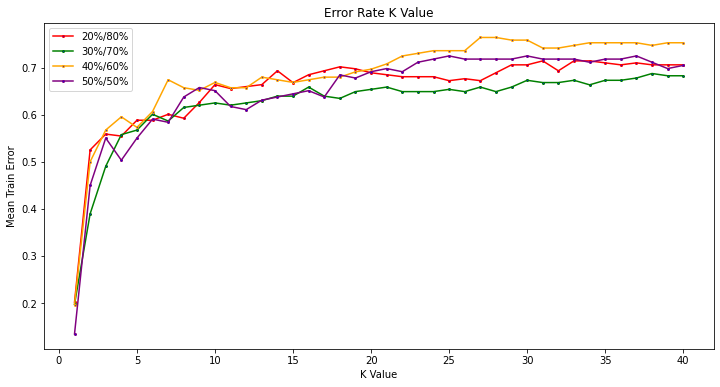

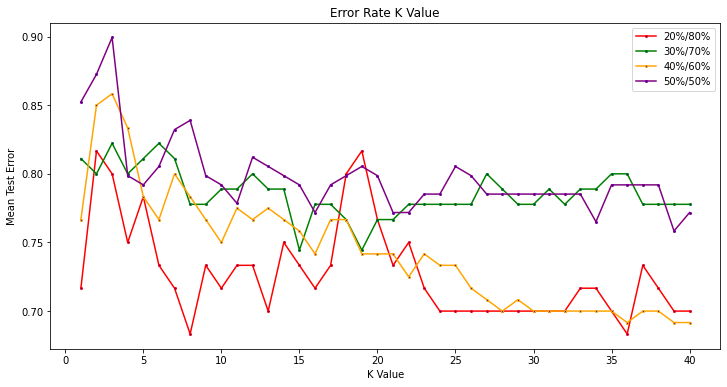

In [17]:
DEFAULT_THRESHOLD = 0.5

X_lev = feature_optimize(X, vectorizer_count, are_words_close, stemming=False, threshold=0.5, debug=False)
visualize_knn_analysis(X_lev, y)

## Анализ результатов

### Классические бинарные метрики, баланс классов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, stratify=y)
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)
classes = ['гнев', 'отвращение', 'горе', 'изумление', 'ужас', 'восхищение', 'восторг', 'настроженность']
report = classification_report(y, knn.predict(X), target_names=classes)
print(report)